In [1]:
import numpy as np
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Convolution2D
from keras.layers import Flatten

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
import pickle
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import SGD
 

Using TensorFlow backend.


In [17]:
def cnn_model():
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
              
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Dropout(0.3))
        
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))
    
    return model

ERROR! Session/line number was not unique in database. History logging moved to new session 246


In [3]:
def cnn_vgg16_model():
    IMAGE_SIZE=[64,64]
    vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    for layer in vgg.layers:
      layer.trainable = False
  
    x = Flatten()(vgg.output)
    # x = Dense(1000, activation='relu')(x)
    prediction = Dense((n_classes), activation='softmax')(x)

    # create a model object
    model = Model(inputs=vgg.input, outputs=prediction)
    
    return model

# image to array conversion

In [5]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = 'dataset'
width=64
height=64
depth=3
loss = 'categorical_crossentropy'
patience = 50


In [6]:
# The callbacks executed during training if model exhibits any following behaviour
log_file_path = directory_root + '_plant_disease.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = directory_root + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]


In [7]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

# loading images

In [8]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    for plant_disease_folder in root_dir:
        print(f"[INFO] Processing {plant_disease_folder} ... ")
        plant_disease_image_list = listdir(f"{directory_root}/{plant_disease_folder}/") 
        
        if plant_disease_folder == 'Blight':
            img_count =2146 
        elif plant_disease_folder == 'Common_Rust':
            img_count = 2498
        elif plant_disease_folder == 'Gray_Leaf_Spot':
            img_count = 1574
        elif plant_disease_folder == 'Healthy':
            img_count = 2324 
        
        
        for image in plant_disease_image_list[:img_count]:
            image_directory = f"{directory_root}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)
                  
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Blight ... 
[INFO] Processing Common_Rust ... 
[INFO] Processing Gray_Leaf_Spot ... 
[INFO] Processing Healthy ... 
[INFO] Image loading completed


### printing size of the dataset

In [9]:
image_size = len(image_list)

print(image_size)

8541


In [10]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)


In [11]:
print(label_binarizer.classes_)

['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']


## image normalisation

In [12]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0
print(np_image_list)

[[[[0.0902   0.3098   0.2274  ]
   [0.1333   0.3333   0.2354  ]
   [0.3372   0.51     0.51    ]
   ...
   [0.02745  0.4548   0.353   ]
   [0.01569  0.4548   0.357   ]
   [0.011765 0.4314   0.3176  ]]

  [[0.1294   0.2705   0.3687  ]
   [0.1412   0.3452   0.4392  ]
   [0.3137   0.4824   0.5254  ]
   ...
   [0.00784  0.4785   0.4119  ]
   [0.02745  0.4902   0.447   ]
   [0.04315  0.506    0.5137  ]]

  [[0.2864   0.4236   0.4902  ]
   [0.5137   0.5293   0.4824  ]
   [0.7686   0.655    0.5605  ]
   ...
   [0.051    0.498    0.5527  ]
   [0.04706  0.4785   0.596   ]
   [0.0549   0.3726   0.5254  ]]

  ...

  [[0.0863   0.498    0.353   ]
   [0.1333   0.5527   0.4236  ]
   [0.1372   0.541    0.4197  ]
   ...
   [0.929    0.788    0.6943  ]
   [0.816    0.6904   0.6704  ]
   [0.4626   0.596    0.541   ]]

  [[0.1765   0.6      0.498   ]
   [0.1412   0.5293   0.3804  ]
   [0.1098   0.5137   0.4158  ]
   ...
   [0.2588   0.4353   0.3293  ]
   [0.04706  0.498    0.349   ]
   [0.0784   0.4863   

## spliting the dataset  

In [13]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [14]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# model selection

In [29]:
select_model_to_run = input("Select the model to run. \n1. CNN model \n2. VGG model\n3. Resnet model\n4. CNN with SVM loss\n")
if(select_model_to_run == '1'):
    model_name = 'cnn'
    print("Model CNN executing ...")
    model = cnn_model()
elif(select_model_to_run == '2'):
    model_name = 'vgg16'
    print("Model VGG16 executing ...")
    model = cnn_vgg16_model()
elif(select_model_to_run == '3'):
    model_name = 'resnet'
    print("Model Resnet executing ...")
    model = resnet()   
elif(select_model_to_run == '4'):
    model_name='cnn_svm'
    loss = 'squared_hinge' # will act as svm the last layer 
    model = cnn_model()
    print("CNN + SVM executing ...")
else:
    print("Invalid selection")
    

Select the model to run. 
1. CNN model 
2. VGG model
3. Resnet model
4. CNN with SVM loss
2
Model VGG16 executing ...


In [30]:
# view the structure of the model
model.summary()
# tell the model what cost and optimization method to use
model.compile(
loss = loss,
optimizer='adam',
metrics=['accuracy']
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [31]:
# fit the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    mode='max')
from keras.callbacks import LearningRateScheduler

lr_sched = LearningRateScheduler(lambda epoch: 1e-4 * (0.75 ** np.floor(epoch / 2)))

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1,
    callbacks=[lr_sched]
    )

Epoch 1/50
213/213 [==============================] - 44s 206ms/step - loss: 1.1842 - accuracy: 0.5737 - val_loss: 1.0882 - val_accuracy: 0.6922
Epoch 2/50
213/213 [==============================] - 36s 171ms/step - loss: 1.0588 - accuracy: 0.7538 - val_loss: 1.0131 - val_accuracy: 0.7940
Epoch 3/50
213/213 [==============================] - 36s 170ms/step - loss: 1.0122 - accuracy: 0.7931 - val_loss: 0.9809 - val_accuracy: 0.8204
Epoch 4/50
213/213 [==============================] - 36s 170ms/step - loss: 0.9865 - accuracy: 0.8156 - val_loss: 0.9602 - val_accuracy: 0.8332
Epoch 5/50
213/213 [==============================] - 36s 170ms/step - loss: 0.9713 - accuracy: 0.8176 - val_loss: 0.9486 - val_accuracy: 0.8426
Epoch 6/50
213/213 [==============================] - 36s 170ms/step - loss: 0.9586 - accuracy: 0.8315 - val_loss: 0.9391 - val_accuracy: 0.8403
Epoch 7/50
213/213 [==============================] - 36s 170ms/step - loss: 0.9537 - accuracy: 0.8312 - val_loss: 0.9326 - val_ac

# plotting graphs

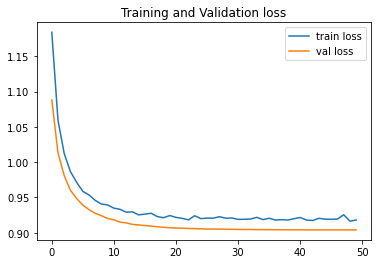

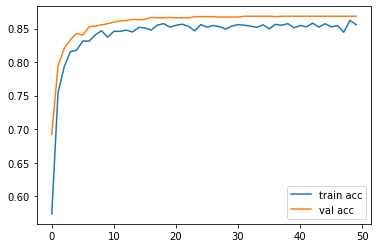

In [32]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation loss')
plt.savefig('LossVal_loss ' + model_name )
plt.legend()
plt.show()


# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.savefig('AccVal_acc ' + model_name)
plt.legend()
plt.show()

In [28]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
1709/1709 [==============================] - 1s 802us/step
Test Accuracy: 70.68461179733276


In [23]:
print("[INFO] Saving model...")
#pickle.dump(model,open('cnn_model_plant.pkl', 'wb'))
model.save(model_name + ' model_plantdisease.h5')

[INFO] Saving model...
